In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lcs import *
import os
import json
import seaborn as sns
import fig_settings as fs

In [2]:
fs.set_fonts({"font.family": "sans-serif"})
models = ["Erdos-Renyi", "SBM", "Watts-Strogatz"]
cfs = [
    "Simple contagion",
    r"Threshold contagion, $\tau=2$",
    r"Threshold contagion, $\tau=3$",
]
keys = ["p", "epsilon", "p"]
labels = [r"$p$", r"$\epsilon$", r"$p$"]

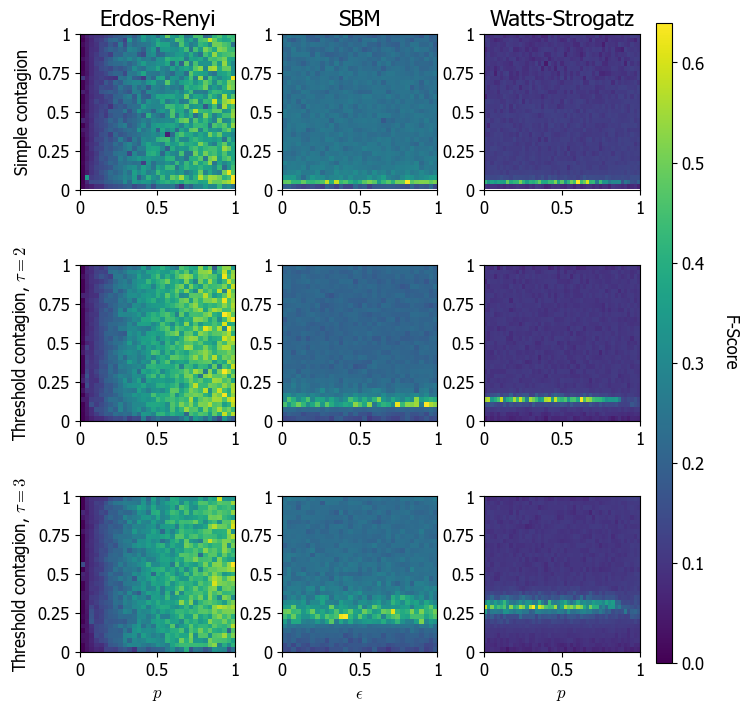

In [8]:
fig, axes = plt.subplots(len(cfs), len(models), figsize=(8, 8))
for i, m in enumerate(models):
    with open(f"Data/{m.lower()}.json") as file:
        data = json.load(file)
    var = np.array(data[keys[i]], dtype=float)
    b = np.array(data["beta"], dtype=float)
    sps = np.array(data["sps"], dtype=float)
    # sps = np.array(data["c"], dtype=float)

    for j, cf in enumerate(cfs):
        # sps_summary = sps[j].max(axis=2).T
        # sps_summary = np.median(sps[j].T, axis=2)
        sps_summary = sps[j].mean(axis=2).T
        im = axes[j, i].imshow(
            to_imshow_orientation(sps_summary),
            extent=(0, 1, 0, 1),
            vmin=0,
            # vmax=1,
        )
        axes[j, i].set_xlim([0, 1])
        axes[j, i].set_ylim([0, 1])
        axes[j, i].set_xticks([0, 0.5, 1], [0, 0.5, 1])
        axes[j, i].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

        if j == 0:
            axes[j, i].set_title(models[i])
        if i == 0:
            axes[j, i].set_ylabel(cfs[j])
        if j == len(cfs) - 1:
            axes[j, i].set_xlabel(labels[i])
fig.subplots_adjust(bottom=0.15, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.3)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"F-Score", fontsize=12, rotation=270, labelpad=25)

# plt.savefig("Figures/Fig2/generative_models.png", dpi=1000)
# plt.savefig("Figures/Fig2/generative_models.pdf", dpi=1000)

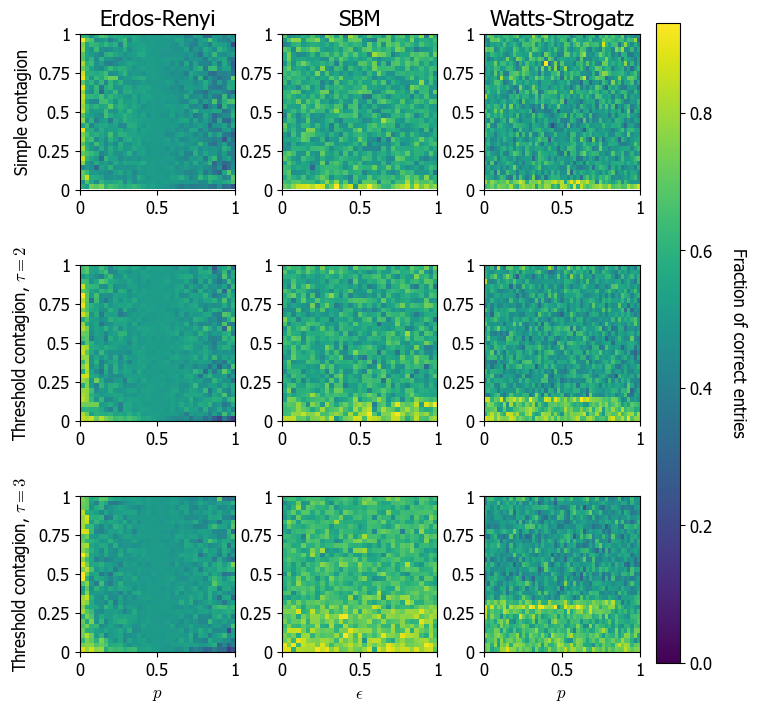

In [11]:
fig, axes = plt.subplots(len(cfs), len(models), figsize=(8, 8))
for i, m in enumerate(models):
    with open(f"Data/{m.lower()}.json") as file:
        data = json.load(file)
    var = np.array(data[keys[i]], dtype=float)
    b = np.array(data["beta"], dtype=float)
    fce = np.array(data["fce"], dtype=float)

    for j, cf in enumerate(cfs):
        fce_summary = fce[j].mean(axis=2).T
        im = axes[j, i].imshow(
            to_imshow_orientation(fce_summary),
            extent=(0, 1, 0, 1),
            vmin=0,
            # vmax=1,
        )
        axes[j, i].set_xlim([0, 1])
        axes[j, i].set_ylim([0, 1])
        axes[j, i].set_xticks([0, 0.5, 1], [0, 0.5, 1])
        axes[j, i].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

        if j == 0:
            axes[j, i].set_title(models[i])
        if i == 0:
            axes[j, i].set_ylabel(cfs[j])
        if j == len(cfs) - 1:
            axes[j, i].set_xlabel(labels[i])
fig.subplots_adjust(bottom=0.15, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.3)
cbar_ax = fig.add_axes([0.82, 0.15, 0.03, 0.8])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"Fraction of correct entries", fontsize=12, rotation=270, labelpad=25)